In [85]:
try:
    import decord
except ImportError:
    raise ImportError(
        "The `decord` package is required for loading the video dataset. Install with `pip install decord`"
    )
from pathlib import Path
from torchvision import transforms
import torch
from matplotlib import pyplot as plt

In [86]:
decord.bridge.set_bridge("torch")


In [87]:
file_path =Path( '/mnt/ceph/develop/jiawei/lora_dataset/Dance-VideoGeneration-Dataset/videos/ffd70401-d960-442f-b240-0be2fb676489_cogv_2b_lora_base_004_test_1_chunk_1511_3.mp4')

In [88]:
video_reader = decord.VideoReader(uri=file_path.as_posix(), width=720, height=480)

torch.Size([480, 720, 3])


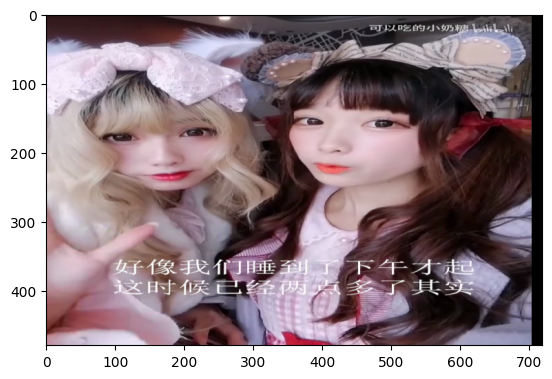

In [89]:
frame = video_reader[0]
print(frame.shape)
plt.imshow(frame)
plt.show()

In [90]:
video_num_frames = len(video_reader)

In [91]:
video_num_frames

71

In [92]:
frames = video_reader.get_batch(list(range(0, video_num_frames)))

In [93]:
frames.shape

torch.Size([71, 480, 720, 3])

In [94]:
selected_num_frames = frames.shape[0]

# Choose first (4k + 1) frames as this is how many is required by the VAE
remainder = (3 + (selected_num_frames % 4)) % 4

In [95]:
remainder

2

In [96]:
if remainder != 0:
    frames = frames[:-remainder]
frames.shape


torch.Size([69, 480, 720, 3])

In [97]:
frames.dtype

torch.uint8

In [98]:

train_transforms = transforms.Compose(
    [
        transforms.Lambda(lambda x: x / 255.0 * 2.0 - 1.0),
    ]
)
frames = torch.stack([train_transforms(frame) for frame in frames], dim=0)
frames = frames.permute(0, 3, 1, 2).contiguous()
 

In [99]:
 
from diffusers.image_processor import VaeImageProcessor
image_np = VaeImageProcessor.pt_to_numpy(frames)  # (to [49, 512, 480, 3])
image_pil = VaeImageProcessor.numpy_to_pil(image_np)

len(image_pil)

69

It is recommended to use `export_to_video` with `imageio` and `imageio-ffmpeg` as a backend. 
These libraries are not present in your environment. Attempting to use legacy OpenCV backend to export video. 
Support for the OpenCV backend will be deprecated in a future Diffusers version


torch.Size([480, 720, 3])


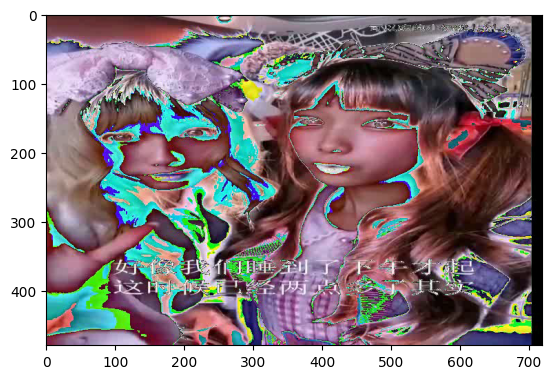

In [100]:

from diffusers.utils import export_to_video
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_path = f"./output/{timestamp}.mp4"
os.makedirs(os.path.dirname(video_path), exist_ok=True)
export_to_video(image_pil, video_path, fps=16)

video_reader = decord.VideoReader(uri=Path(video_path).as_posix())

frame = video_reader[0]
print(frame.shape)
plt.imshow(frame)
plt.show()


#### video fix float

In [101]:
video_reader = decord.VideoReader(uri=file_path.as_posix(), width=720, height=480)
video_num_frames = len(video_reader)
frames = video_reader.get_batch(list(range(0, video_num_frames)))
selected_num_frames = frames.shape[0]

# Choose first (4k + 1) frames as this is how many is required by the VAE
remainder = (3 + (selected_num_frames % 4)) % 4
if remainder != 0:
    frames = frames[:-remainder]
frames.shape


torch.Size([69, 480, 720, 3])

In [102]:

tensor = frames.float() / 255.0
frames = tensor.permute(0, 3, 1, 2)
frames.shape

torch.Size([69, 3, 480, 720])

It is recommended to use `export_to_video` with `imageio` and `imageio-ffmpeg` as a backend. 
These libraries are not present in your environment. Attempting to use legacy OpenCV backend to export video. 
Support for the OpenCV backend will be deprecated in a future Diffusers version


torch.Size([480, 720, 3])


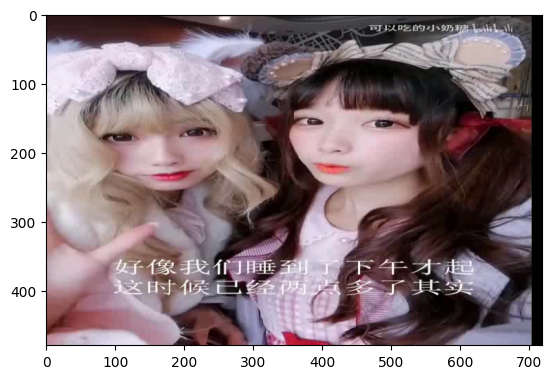

In [103]:
 
from diffusers.image_processor import VaeImageProcessor
image_np = VaeImageProcessor.pt_to_numpy(frames)  # (to [49, 512, 480, 3])
image_pil = VaeImageProcessor.numpy_to_pil(image_np)


from diffusers.utils import export_to_video
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_path = f"./output/{timestamp}.mp4"
os.makedirs(os.path.dirname(video_path), exist_ok=True)
export_to_video(image_pil, video_path, fps=16)


video_reader = decord.VideoReader(uri=Path(video_path).as_posix())

frame = video_reader[0]
print(frame.shape)
plt.imshow(frame)
plt.show()


#### resize_for_rectangle_crop

torch.Size([960, 720, 3])


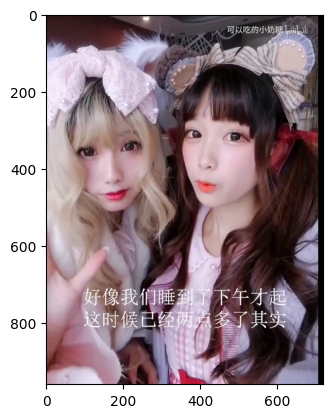

In [104]:
video_reader = decord.VideoReader(uri=file_path.as_posix())

frame = video_reader[0]
print(frame.shape)
plt.imshow(frame)
plt.show()


In [105]:
 
video_num_frames = len(video_reader)
frames = video_reader.get_batch(list(range(0, video_num_frames)))
selected_num_frames = frames.shape[0]

# Choose first (4k + 1) frames as this is how many is required by the VAE
remainder = (3 + (selected_num_frames % 4)) % 4
if remainder != 0:
    frames = frames[:-remainder]
frames.shape

 
tensor = frames.float() / 255.0
frames = tensor.permute(0, 3, 1, 2)
frames.shape

torch.Size([69, 3, 960, 720])

In [106]:
from torchvision.transforms.functional import center_crop, resize
from torchvision.transforms import InterpolationMode
import torchvision.transforms as TT

def resize_for_rectangle_crop(arr, image_size, reshape_mode="random"):
    if arr.shape[3] / arr.shape[2] > image_size[1] / image_size[0]:
        arr = resize(
            arr,
            size=[image_size[0], int(arr.shape[3] * image_size[0] / arr.shape[2])],
            interpolation=InterpolationMode.BICUBIC,
        )
    else:
        arr = resize(
            arr,
            size=[int(arr.shape[2] * image_size[1] / arr.shape[3]), image_size[1]],
            interpolation=InterpolationMode.BICUBIC,
        )

    h, w = arr.shape[2], arr.shape[3]
    arr = arr.squeeze(0)

    delta_h = h - image_size[0]
    delta_w = w - image_size[1]

    if reshape_mode == "random" or reshape_mode == "none":
        top = np.random.randint(0, delta_h + 1)
        left = np.random.randint(0, delta_w + 1)
    elif reshape_mode == "center":
        top, left = delta_h // 2, delta_w // 2
    else:
        raise NotImplementedError
    arr = TT.functional.crop(arr, top=top, left=left, height=image_size[0], width=image_size[1])
    return arr
 

In [107]:
 
tensor_frms = resize_for_rectangle_crop(frames,  ( 480, 720 ), reshape_mode="center")
tensor_frms = tensor_frms.contiguous()

In [108]:


tensor_frms.shape

torch.Size([69, 3, 480, 720])

It is recommended to use `export_to_video` with `imageio` and `imageio-ffmpeg` as a backend. 
These libraries are not present in your environment. Attempting to use legacy OpenCV backend to export video. 
Support for the OpenCV backend will be deprecated in a future Diffusers version


torch.Size([480, 720, 3])


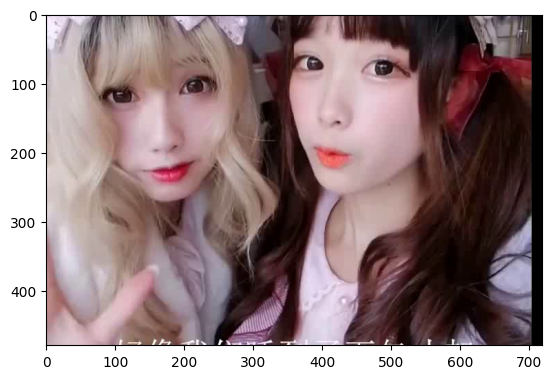

In [109]:
 
from diffusers.image_processor import VaeImageProcessor
image_np = VaeImageProcessor.pt_to_numpy(tensor_frms)  # (to [49, 512, 480, 3])
image_pil = VaeImageProcessor.numpy_to_pil(image_np)


from diffusers.utils import export_to_video
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_path = f"./output/{timestamp}.mp4"
os.makedirs(os.path.dirname(video_path), exist_ok=True)
export_to_video(image_pil, video_path, fps=16)


video_reader = decord.VideoReader(uri=Path(video_path).as_posix())

frame = video_reader[0]
print(frame.shape)
plt.imshow(frame)
plt.show()
